# Exercise 2

The exercise focuses on implementing a small feedforward neural network and training it on the MNIST dataset.
We recommend looking at Chapter 6 in the "Deep Learning" book.

We provide code for structure and utility, you have to **fill in the TODO-gaps**.
It might initially look like a lot of unnecessary code, but it keeps the network extensible. In the following exercises you can reuse what you've done here. Most common neural network libraries (*pytorch*, *tensorflow/keras*, …) are similarly structured, hence they will be easy to use once you've finished this notebook. As we will be using *pytorch* towards the end of the lecture, our API resembles the API of the pytorch framework.


We will implement two different cost functions and play a bit with the value of the different hyperparameters to see how performances change as a function of those. In particular, we will focus on

* Nonlinear activation functions
* Multi-Layer Perceptrons (MLP) a.k.a. Feed-forward neural networks.
* Quadratic Cost Function
* Cross Entropy Cost Function

Note that we'll implement all of these operations to operate on batches of data.

In [166]:
# Some imports used in the code below

from typing import Iterable, List, Optional, Tuple  # type annotations

import numpy as np  # linear algebra
import matplotlib.pyplot as plt  # plotting
import scipy.optimize  # gradient check

The cell below contains the two main classes to structure your network. 

**Parameter** is used to represent trainable variables in the network, e.g., a layer's weights $w$. The weights themself are a *numpy array* as the parameter's `data` attribute. The associated parameter gradient (e.g. $\frac{\partial L}{\partial w}$) can be stored in the `grad` attribute.



**Module** is the base class for all parts of the network (activations, layers, …) and even the network itself. They all have to implement the `forward` and `backward` methods. For backpropagation activation will flow *forward* and gradient will flow *backward* through the *network graph and it's modules*. 

Additional module provides utility to check the correctness of implementation by approximating *backward* with [finite difference approximations](https://en.wikipedia.org/wiki/Finite_difference#Relation_with_derivatives)  of *forward*.

*Note:* All modules operate on batches of samples. E.g. the input shape of `Linear.forward` is `(batch_size, feature_shape, 1)` (we will use the last dimension in future exercises). In this exercise we will not make use of gradients and the backwards method. In the next exercise we will see how one can update the weights of a neural network using backpropagation.

In [167]:
class Parameter:
    """A trainable parameter.

    This class not only stores the value of the parameter (self.data) but also tensors/
    properties associated with it, such as the gradient (self.grad) of the current backward
    pass.
    """

    def __init__(self, data: np.ndarray, grad: Optional[np.ndarray] = None, name=None):
        self.data = data  # type: np.ndarray
        self.grad = grad  # type: Optional[np.ndarray]
        self.name = name  # type: Optional[str]
        self.state_dict = dict()  # dict to store additional, optional information
        
        
class Module:
    """The base class all network modules must inherit from."""

    def __init__(self):
        # Cache of the input of the forward pass.
        # We need it during the backward pass in most layers,
        #  e.g., to compute the gradient w.r.t to the weights.
        self.input_cache = None

    def __call__(self, *args) -> np.ndarray:
        """Alias for forward, convenience function."""
        return self.forward(*args)

    def forward(self, *args) -> np.ndarray:
        """Compute the forward pass through the module.

        Args:
           args: The inputs, e.g., the output of the previous layer.
        """
        raise NotImplementedError

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Compute the backward pass through the module.

        This method computes the gradients with respect to the trainable
        parameters and with respect to the first input.
        If the module has trainable parameters, this method needs to update
        the respective parameter.grad property.

        Args:
            grad: The gradient of the following layer.

        Returns:
            The gradient with respect to the first input argument. In general
            it might be useful to return the gradients w.r.t. to all inputs, we
            omit this here to keep things simple.
        """
        raise NotImplementedError

    def parameters(self) -> List[Parameter]:
        """Return the module parameters."""
        return []  # default to empty list

    def check_gradients(self, input_args: Tuple[np.ndarray]):
        """Verify the implementation of the gradients.

        This includes the gradient with respect to the input as well as the
        gradients w.r.t. the parameters if the module contains any.

        As the scipy grad check only works on scalar functions, we compute
        the sum over the output to obtain a scalar.
        """
        assert isinstance(input_args, tuple), (
            "input_args must be a tuple but is {}".format(type(input_args)))
        TOLERANCE = 1e-6
        self.check_gradients_wrt_input(input_args, TOLERANCE)
        self.check_gradients_wrt_params(input_args, TOLERANCE)

    def _zero_grad(self):
        """(Re-) intialize the param's grads to 0. Helper for grad checking."""
        for p in self.parameters():
            p.grad = np.zeros_like(p.data)

    def check_gradients_wrt_input(self, input_args: Tuple[np.ndarray],
                                  tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. input."""

        def output_given_input(x: np.ndarray):
            """Wrap self.forward for scipy.optimize.check_grad."""
            # we only compute the gradient w.r.t. to the first input arg.
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            return np.sum(self.forward(*args))

        def grad_given_input(x: np.ndarray):
            """Wrap self.backward for scipy.optimize.check_grad."""
            self._zero_grad()
            # run self.forward to store the new input
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            out = self.forward(*args)
            # compute the gradient w.r.t. to the input
            return np.ravel(self.backward(np.ones_like(out)))

        error = scipy.optimize.check_grad(
            output_given_input, grad_given_input, np.ravel(input_args[0]))
        num_outputs = np.prod(self.forward(*input_args).shape)
        if np.squeeze(error) / num_outputs > tolerance:
            raise RuntimeError("Check of gradient w.r.t. to input for {} failed."
                               "Error {:.4E} > {:.4E}."
                               .format(self, np.squeeze(error), tolerance))

    def check_gradients_wrt_params(self, input_args: Tuple[np.ndarray],
                                   tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. params."""
        for param in self.parameters():
            def output_given_params(new_param: np.ndarray):
                """Wrap self.forward, change the parameters to new_param."""
                param.data = new_param.reshape(param.data.shape)
                return np.sum(self.forward(*input_args))

            def grad_given_params(new_param: np.ndarray):
                self._zero_grad()
                param.data = new_param.reshape(param.data.shape)
                out = self.forward(*input_args)
                # compute the gradient w.r.t. to param
                self.backward(np.ones_like(out))
                return np.ravel(param.grad)
            # flatten the param as scipy can only handle 1D params
            param_init = np.ravel(np.copy(param.data))
            error = scipy.optimize.check_grad(output_given_params,
                                              grad_given_params,
                                              param_init)
            num_outputs = np.prod(self.forward(*input_args).shape)
            if np.squeeze(error) / num_outputs > tolerance:
                raise RuntimeError("Check of gradient w.r.t. to param '{}' for"
                                   "{} failed. Error {:.4E} > {:.4E}."
                                   .format(param.name, self, error, tolerance))

# Nonlinearities

## Sigmoid (1 point)

Implement your first network module: The sigmoid activation function.

Verify your sigmoid function by plotting.

In [168]:
class Sigmoid(Module):
    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        # START TODO ################
#         raise NotImplementedError
        return 1.0/(1.0 + np.exp(-z))
        # END TODO###################

    def forward(self, z: np.ndarray) -> np.ndarray:
        assert len(z.shape) == 3, ("z.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(z.shape))
        h = self._sigmoid(z)
        # here it's useful to store the activation 
        #  instead of the input
        self.input_cache = h
        
        return h

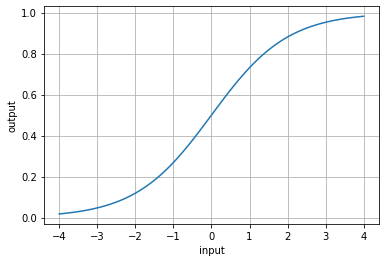

In [169]:
x = np.linspace(-4, +4, 100)
sigmoid = Sigmoid()

y = np.ravel(sigmoid(x.reshape(-1, 1, 1)))
# equal to call of sigmoid.forward(x)
    
plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()

In [170]:
x = np.linspace(-4, +4, 100)
t = x.reshape(-1, 1, 1)
t.shape
t_zeros = np.zeros(t.shape)
t_zeros.shape
t2 = np.array([[1, 2, 4],
              [14, 255, 47]])
t3 = t2.ravel()
t3.shape

(6,)

## Relu (1 + 0.5 points)

Implement Relu and plot for verification

In [171]:
class Relu(Module):
    def forward(self, z: np.ndarray) -> np.ndarray:
        self.input_cache = z
        # START TODO ################
#         raise NotImplementedError
        z_zeros = np.zeros(z.shape)
        return np.maximum(z, z_zeros)
        
        # END TODO###################

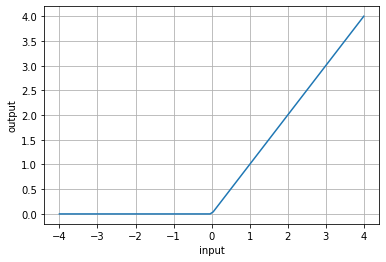

In [172]:
# Plot Relu
x = np.linspace(-4.0, 4.0, 100)
relu = Relu()

# START TODO ################
y = np.ravel(relu.forward(x.reshape(-1, 1, 1)))
plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()
# END TODO###################

## Softmax (1 point)

Implement the numerical stable softmax. We will not need the backward pass. 

In [173]:
class Softmax(Module):
    def _softmax(self, z):
        # don't reduce (sum) over batch axis
        reduction_axes = tuple(range(1, len(z.shape))) 
        
        # START TODO ################
        dr = np.sum(np.exp(z), reduction_axes)
        h = np.exp(z)/dr
#         raise NotImplementedError
        
        # Shift input for numerical stability.
        # END TODO###################
        return h
    
    def forward(self, z: np.ndarray) -> np.ndarray:
        h = self._softmax(z)
        return h

In [174]:
# Check your softmax
softmax = Softmax()
x = np.array([1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0]).reshape(1, -1, 1)

# Testcase from https://en.wikipedia.org/wiki/Softmax_function#Example
np.testing.assert_allclose(
    np.ravel(softmax(x)), 
    [0.02364054, 0.06426166, 0.1746813, 0.474833, 0.02364054, 0.06426166, 0.1746813],
    rtol=1e-5, err_msg="Softmax is not correct implemented")


In [175]:
x = np.array([1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0]).reshape(1, -1, 1)
print(x.shape)

(1, 7, 1)


# Linear Layer (2 points)

Implement a linear (in other frameworks also called dense or fully connected) network layer. 
Here you also have to use the Parameter class.

In [176]:
t = np.array([[12, 65, 53],
             [46, 42, 88]])

t3 = np.expand_dims(t, -1)
print(t3.shape, t.shape)
t5 = np.dot(t3.T, t)
print("t5: ",t5.shape)

(2, 3, 1) (2, 3)
t5:  (1, 3, 3)


In [177]:
class Linear(Module):

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        
        w_data = 0.01 * np.random.randn(out_features, in_features)
#         w_data = np.expand_dims(w_data, -1)
        self.W = Parameter(w_data, "W")
        
        b_data = 0.01 * np.ones((out_features, 1))
        self.b = Parameter(b_data, "b")

    def forward(self, x: np.ndarray) -> np.ndarray:
        assert len(x.shape) == 3, ("x.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(x.shape))
#         print("w_data: ",self.W.data)
#         print("b_data: ",self.b.data)
        self.input_cache = x
        # START TODO ################
        # Remember: Access weight data through self.W.data
        return np.matmul(self.W.data, x) + self.b.data
        # END TODO ##################
         

    def parameters(self) -> List[Parameter]:
        # START TODO ################ 
        # Return all parameters of Linear
#         raise NotImplementedError
        return self.W.data, self.b.data
        # END TODO ##################

In [178]:
#Linear class test case
linu = Linear(2, 2)
X = np.array([[12, 34, 54, 67],
             [12, 34, 54, 67]]).reshape(4,2,1)
W1 = np.array([[1, 1],
             [1, 1]])
c1 = np.array([0, -1]).reshape(2, 1)
linu.W = Parameter(W1, "weight1")
linu.b = Parameter(c1, "bias1")

result = linu.forward(X)
assert result.shape == (4, 2, 1)

# Cost Functions (1 point)



In [201]:
# Define the Cross-Entropy cost functions
class CrossEntropyLoss(Module):
    """Compute the cross entropy."""

    def __init__(self):
        super().__init__()
        self.softmax = Softmax()

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Compute the cross entropy, mean over batch size."""
        a = self.softmax(a)
        self.input_cache = a, y
        # compute the mean over the batch
        # START TODO ################ 
#         return NotImplementedError

        N = y.shape[0]
        print(f'y:{y}, a:{a}, np.log(a):{np.log(a)}, y * np.log(a): {y * np.log(a)}')
        return -(1/N) * np.sum(y * np.log(a))
        # END TODO ##################


class MSELoss(Module):
    """Compute the mean squared error loss."""

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        self.input_cache = a, y
        return np.sum(0.5 * np.linalg.norm(a - y, axis=-1)**2) / len(a)




# Sequential Network (1 point)

In [202]:
class Sequential(Module):
    """A sequential container to stack modules.

    Modules will be added to it in the order they are passed to the
    constructor.

    Example network with one hidden layer:
    model = Sequential(
                  Linear(5,10),
                  ReLU(),
                  Linear(10,10),
                )
    """
    def __init__(self, *args: List[Module]):
        super().__init__()
        self.modules = args

    def forward(self, x: np.ndarray) -> np.ndarray:
        # START TODO ################ 
#         raise NotImplementedError
        # Remember: module(x) is equivalent to module.forward(x)
        for module in self.modules:
            x = module.forward(x)
#             print("module: ", module,"value: ", x)
        # END TODO ##################
        return x

    def parameters(self) -> List[Parameter]:
        # iterate over modules and retrieve their parameters, iterate over
        # parameters to flatten the list
        return [param for module in self.modules
                for param in module.parameters()]

# Experiments

We will now implement a simple multilayer perceptron whose output aprroximates the output of the [XOR](https://en.wikipedia.org/wiki/XOR_gate) operation. At this point we are not concerned to generalize; we only care to learn a function that can classify each pair in $X = \{ [0,0]^T, [0,1]^T, [1,0]^T, [1,1]^T \}$ to one of the classes in $Y = \{ 0, 1 \}$.

In [203]:
# training set
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

# true labels
Y = np.array([0, 1, 1, 0],)
Y.shape

(4,)


1) Fit a logistic regression model to the X data. What is the predicted output and the best accuracy you can achieve? (1 point)

**HINT**: *You can use* [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) *with the LBFGS solver.*

In [204]:
from sklearn.linear_model import LogisticRegression

def logistic_regression(x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, float]:
    """ Implement a logistic regression model for binary classification.
  Args:
    x: np.ndarray with shape (nr_examples, nr_features). Input examples.
    y: np.ndarray with shape (nr_examples,). True labels.

  Returns:
    Tuple[prediction, score]:
      prediction: np.ndarray with shape (nr_examples,). Predicted labels.
      score: float. Overall score of the model.
  """
  # START TODO ################
#     return NotImplementedError
    clf = LogisticRegression(solver = 'lbfgs').fit(x, y)
    prediction = clf.predict(x)
    score = clf.score(x, y)
    return [prediction, score]
  # END TODO ##################

In [205]:
p, s = logistic_regression(X, Y)
p
s

0.5

2) *Now define a sequential model (Linear, Relu, Linear) with 2 hidden units. Our model output will therefore be computed as:* $ f(x) = w^T max\{ 0, W^TX + c \} + b ,$ *where $W = \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix}$, $c = \begin{bmatrix} 0 \\ -1 \end{bmatrix}$, $w = \begin{bmatrix} 1 \\ -2 \end{bmatrix}$ and $b = 0$. For this part you have to:*
  * instantiate the sequential model. (1 point)
  * set the weights of the sequential model to the corresponding minimizer's values as shown above. (0.5 points)
  * Propagate the input examples through the network to get the output. (0.5 points)
  * Compute the cross entropy loss. (0.5 points)

*NOTE: These parameters are actually the minimizers of some cost, e.g. one of the cost functions shown above. In the next exercise, we will learn how backpropagation is used to find these minimizers of the cost function using gradient descent.*

In [206]:
# START TODO ################ 
# Define the model here!
linear1 = Linear(in_features=2, out_features=2)

linear2 = Linear(in_features=2, out_features=1)

relu = Relu()
model = Sequential(
                  linear1,
                  relu,
                  linear2
                )
# END TODO ##################

In [207]:
# START TODO ################
# change the model weights
W1 = np.array([[1, 1],
             [1, 1]])
c1 = np.array([0, -1]).reshape(-1, 1)
linear1.W = Parameter(W1, "weight1")
linear1.b = Parameter(c1, "bias1")

W2 = np.array([1, -2]).reshape(1, 2)
c2 = 0.0
linear2.W = Parameter(W2, "weight2")
linear2.b = Parameter(c2, "bias2")
# END TODO ##################

In [208]:
# expand the shape of the input tensor
x = np.expand_dims(X, -1)

def predict(model: Module, input_data: np.ndarray, output_size: int=1) -> np.ndarray:
    """
        Propagate the input through the network and return the output.
        Args:
        model: Module. Sequential model representing the neural network
        input_data: np.ndarray of shape (nr_examples, nr_features). Input data.
        output_size: int. The output neurons in the MLP. This would be 1 for a binary classification task.
        Returns:
        prediction: np.ndarray of shape (nr_examples, output_size)
    """
    # START TODO ################
    # propagate the input_data through the model and reshape accordingly 
    # to (nr_examples, output_size)
    prediction = model.forward(input_data)
#     assert prediction.shape == (np.shape(input_data)[0], output_size)

    # END TODO ##################
    return prediction

In [220]:
prediction = predict(model, x)
print( prediction.shape)

assert np.array_equal(np.ravel(prediction), np.array([0, 1, 1, 0]))

(4, 1, 1)


In [221]:
loss_fn = CrossEntropyLoss()
# loss = loss_fn.forward(prediction.reshape(4, 1), Y.reshape(4,1))
loss = loss_fn.forward(prediction.flatten(), Y.flatten())

# START TODO ###
#############
# given the true labels Y and the predictions compute the cross entropy loss defined above
# x_test = np.array([0,1,1,0])
# loss = loss_fn(x_test, x_test)
# END TODO ##################
print(loss)

assert loss == -.0

y:[0 1 1 0], a:[1. 1. 1. 1.], np.log(a):[0. 0. 0. 0.], y * np.log(a): [0. 0. 0. 0.]
-0.0


In [222]:
t = np.array([[12, 34, 56, 56],
             [12, 34, 45, 57]])
t1 = t.flatten()
t2 = t.reshape(-1,1)
print(f't1:{t1}, t2: {t2}, t2.shape:{t2.shape},t1.shape:{t1.shape}')

t1:[12 34 56 56 12 34 45 57], t2: [[12]
 [34]
 [56]
 [56]
 [12]
 [34]
 [45]
 [57]], t2.shape:(8, 1),t1.shape:(8,)


3) Instantiate a new sequential model with 3 hidden units this time. Assign the correct values to the model parameters such that the output of the neural network remains the same as in the model with 2 hidden units. How many minimizers does the neural network have in this case? (1.5 points)

In [ ]:
# START TODO ################ 
# Define the model here!

# END TODO ##################

In [ ]:
# START TODO ################
# change the model weights

# END TODO ##################

In [55]:
prediction = predict(model_3units, x)
print(prediction)

assert np.array_equal(np.ravel(prediction), np.array([0, 1, 1, 0]))

NameError: name 'model_3units' is not defined

(BONUS): After transforming the input data into the hidden representation space, generate two plots showing the dataset in the input and representation spaces, respectively (the same as the one in Figure 6.1, [Chapter 6, Deep Learnig Book](http://www.deeplearningbook.org/contents/mlp.html)). (1.5 points)

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def plot(x1: np.ndarray, x2: np.ndarray, h1: np.ndarray, h2: np.ndarray, y: np.ndarray):
  """
  Args:
    x1: np.ndarray with shape (nr_examples,). First input features.
    x2: np.ndarray with shape (nr_examples,). Second input feature.
    h1: np.ndarray with shape (nr_examples,). First learned features.
    h2: np.ndarray with shape (nr_examples,). Second learned feature.
    y: np.ndarray with shape (nr_examples,). True labels.
  """
  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    for k, (i, j) in enumerate(zip(x1, x2)):
        ax[0].scatter(i, j, c='b', marker=r"${}$".format(y[k]), s=100)
    for k, (i, j) in enumerate(zip(h1, h2)):
        ax[1].scatter(i, j, c='b', marker=r"${}$".format(y[k]), s=100)

    ax[0].set_yticks([0, 1])
    ax[0].set_xticks([0, 1])
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
#     ax[0].set_title("Original x space")

    ax[1].set_yticks([0, 1])
    ax[1].set_xticks([0, 1, 2])
    ax[1].set_xlabel('h1')
    ax[1].set_ylabel('h2')
    ax[1].set_title("Learned h space")

    plt.show()

In [ ]:
def extract_hidden(full_model: Module, x: np.ndarray) -> np.ndarray:
  """ Function to extraxt the hidden representation from a MLP.
  Args:
    full_model: Module. The sequential model used as a classifier
    x: np.ndarray with shape (nr_examples, nr_features). Input examples
  Returns:
    h: np.ndarray with shape (nr_examples, nr_features). Hidden representation of inputs.
  """
  # START TODO ################ 
  # Extract the hidden features from the sequential model defined above and
  # compute the hidden representation after propagating the input through
  # the first Linear layer and the ReLU function.

  # END TODO ##################

h = extract_hidden(model, X)
plot(X[:, 0], X[:, 1], h[:, 0], h[:, 1], Y.flatten())

** Your feedback on exercise 2: ** 
